### Imports

In [1]:
!pip install ultralytics
!pip install opencv-python
!pip install easyocr
!pip install pillow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import easyocr

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

### Load YOLOv11 model trained on Google Colab

In [3]:
from ultralytics import YOLO

model = YOLO("my_model.pt")

### Load and upscale image

In [4]:
def invert_non_black_words(img_rgb, black_threshold=50):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    text_pixels = gray[binary == 255]
    if len(text_pixels) == 0:
        # if no text detected, return as is
        return img_rgb
    
    # mean brightness of text pixels
    mean_text_brightness = np.mean(text_pixels)
    
    # if text is not black, invert colours
    if mean_text_brightness > black_threshold:
        inverted = cv2.bitwise_not(img_rgb)
        return inverted
    else:
        return img_rgb

In [5]:
# load image
img = cv2.imread('test2.jpg')
img = invert_non_black_words(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
scale = 8.0
h, w = img.shape[:2]
new_w, new_h = int(w * scale), int(h * scale)

upscaled_img = cv2.resize(
    img,
    (new_w, new_h),
    interpolation=cv2.INTER_CUBIC
)

results = model(upscaled_img, conf=0.4, verbose=False)
res = results[0]
res

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'License_Plate'}
obb: None
orig_img: array([[[239, 234, 231],
        [239, 234, 231],
        [239, 234, 231],
        ...,
        [173, 161, 145],
        [173, 161, 145],
        [173, 161, 145]],

       [[239, 234, 231],
        [239, 234, 231],
        [239, 234, 231],
        ...,
        [173, 161, 145],
        [173, 161, 145],
        [173, 161, 145]],

       [[239, 234, 231],
        [239, 234, 231],
        [239, 234, 231],
        ...,
        [173, 161, 145],
        [173, 161, 145],
        [173, 161, 145]],

       ...,

       [[113, 120, 113],
        [113, 120, 113],
        [113, 120, 113],
        ...,
        [114, 117, 110],
        [114, 117, 110],
        [114, 117, 110]],

       [[113, 120, 113],
        [113, 120, 113],
        [113, 120, 113],
        ...,
        [114, 117, 110],
        [114, 117, 110],
      

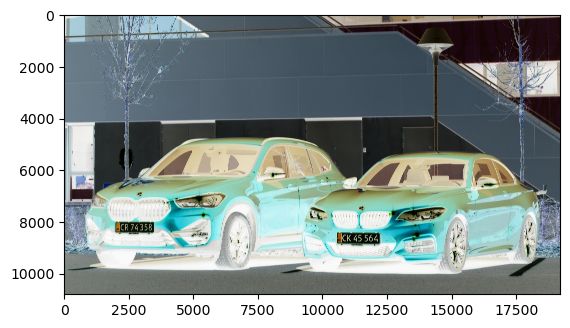

In [6]:
original_image = res.orig_img
plt.imshow(original_image)

In [7]:
## (N×4) tensor of absolute [x1, y1, x2, y2]
res.boxes.xyxy

tensor([[ 1936.1841,  8014.9131,  3505.4998,  8478.3320],
        [10486.2715,  8367.0078, 12297.5596,  8887.9932]])

In [8]:
## classes, but in this case only have 1 class: {0: 'License_Plate'}
res.boxes.cls

tensor([0., 0.])

In [9]:
## (N×6) tensor where each row is [x1, y1, x2, y2, confidence_level, class]
res.boxes.data.numpy()

array([[     1936.2,      8014.9,      3505.5,      8478.3,     0.65114,           0],
       [      10486,        8367,       12298,        8888,     0.62467,           0]], dtype=float32)

In [10]:
boxes_data = res.boxes.data.numpy()
crop_areas = []
for i, (x1, y1, x2, y2, conf, _) in enumerate(boxes_data):
    x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
    crop_areas.append((x1, y1, x2, y2))
    print(f"Box {i}\nTop-left pixel coordinates:({x1}, {y1})\nBottom-right pixel coordinates:({x2}, {y2})\nConfidence level={conf:.2f}\n")

Box 0
Top-left pixel coordinates:(1936, 8014)
Bottom-right pixel coordinates:(3505, 8478)
Confidence level=0.65

Box 1
Top-left pixel coordinates:(10486, 8367)
Bottom-right pixel coordinates:(12297, 8887)
Confidence level=0.62



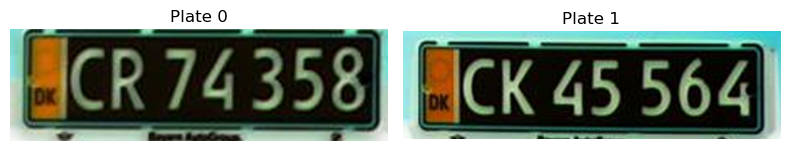

In [11]:
cropped_images = []
n = len(crop_areas)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))

for idx, (x1, y1, x2, y2) in enumerate(crop_areas):
    crop = original_image[y1:y2, x1:x2]
    cropped_images.append(crop)
    axes[idx].imshow(crop)
    axes[idx].axis('off')
    axes[idx].set_title(f"Plate {idx}")

plt.tight_layout()
plt.show()

In [12]:
from PIL import Image, ImageFilter

def upscale(input_img):
    scale = 8.0
    
    pil_img = Image.fromarray(input_img)
    
    up = pil_img.resize(
        (int(pil_img.width * scale), int(pil_img.height * scale)),
        resample=Image.BICUBIC
    )
    up = up.filter(ImageFilter.UnsharpMask(radius=1.0, percent=90, threshold=3))
    
    if up.mode == "RGB":
        cv_up = cv2.cvtColor(np.array(up), cv2.COLOR_RGB2BGR)
    elif up.mode == "RGBA":
        cv_up = cv2.cvtColor(np.array(up), cv2.COLOR_RGBA2BGRA)
    else:
        cv_up = np.array(up)  # grayscale

    return cv_up


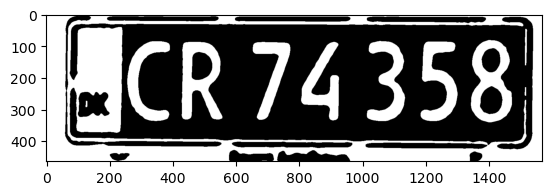

In [13]:
processed = []
clahe = cv2.createCLAHE(clipLimit=0.001, tileGridSize=(7,7))
illum_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,13))
clean_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

for img in cropped_images:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = clahe.apply(gray)
    
    tophat  = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT,  illum_kernel)
    blackhat= cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, illum_kernel)
    norm = cv2.add(gray, tophat)
    norm = cv2.subtract(norm, blackhat)

    blur = cv2.GaussianBlur(norm, (15,15), 0)
    res = upscale(blur)
    th1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)[1]
    th2 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    candidates = [th1, th2]
    bw = min(candidates, key=cv2.countNonZero)

    res = cv2.morphologyEx(bw, cv2.MORPH_OPEN, clean_kernel, iterations=3)
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, clean_kernel, iterations=1)
    
    processed.append(res)

plt.imshow(processed[0], cmap='gray')

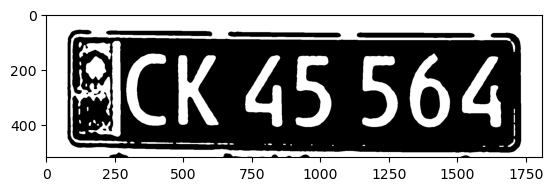

In [14]:
plt.imshow(processed[1], cmap='gray')

In [15]:
reader = easyocr.Reader(['en'])
extracted_plate_strings = []

for img in processed:
    detections = reader.readtext(
        img,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
        detail=1
    )
    
    if not detections:
        print("No text detected in this crop.")
        extracted_plate_strings.append(None)
        continue
    
    bbox, text, prob = detections[0]
    print(f"Text: {text}, Probability: {prob:.4f}")
    extracted_plate_strings.append(text)

Text: CR74358, Probability: 0.9987
Text: CK45564, Probability: 0.9999


## Helper Functions

In [16]:
def invert_non_black_words(img_rgb, black_threshold=50):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    text_pixels = gray[binary == 255]
    if len(text_pixels) == 0:
        # if no text detected, return as is
        return img_rgb
    
    # mean brightness of text pixels
    mean_text_brightness = np.mean(text_pixels)
    
    # if text is not black, invert colours
    if mean_text_brightness > black_threshold:
        inverted = cv2.bitwise_not(img_rgb)
        return inverted
    else:
        return img_rgb

In [17]:
def upscale_and_detect(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    scale = 8.0
    h, w = img.shape[:2]
    new_w, new_h = int(w * scale), int(h * scale)
    
    upscaled_img = cv2.resize(
        img,
        (new_w, new_h),
        interpolation=cv2.INTER_CUBIC
    )

    results = model(upscaled_img, conf=0.4, verbose=False)
    return results[0]

In [18]:
from PIL import Image, ImageFilter

def upscale(input_img):
    scale = 8.0
    
    pil_img = Image.fromarray(input_img)
    
    up = pil_img.resize(
        (int(pil_img.width * scale), int(pil_img.height * scale)),
        resample=Image.BICUBIC
    )
    up = up.filter(ImageFilter.UnsharpMask(radius=1.0, percent=90, threshold=3))
    
    if up.mode == "RGB":
        cv_up = cv2.cvtColor(np.array(up), cv2.COLOR_RGB2BGR)
    elif up.mode == "RGBA":
        cv_up = cv2.cvtColor(np.array(up), cv2.COLOR_RGBA2BGRA)
    else:
        cv_up = np.array(up)  # grayscale

    return cv_up


In [19]:
def crop_license_plates(res):
    original_image = res.orig_img
    boxes_data = res.boxes.data.numpy()
    
    crop_areas = []
    for i, (x1, y1, x2, y2, conf, _) in enumerate(boxes_data):
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        crop_areas.append((x1, y1, x2, y2))
        # print(f"Box {i}\nTop-left pixel coordinates:({x1}, {y1})\nBottom-right pixel coordinates:({x2}, {y2})\nConfidence level={conf:.2f}\n")

    cropped_images = []
    for idx, (x1, y1, x2, y2) in enumerate(crop_areas):
        crop = original_image[y1:y2, x1:x2]
        cropped_images.append(crop)

    return cropped_images

In [20]:
def process_images(cropped_images):
    processed = []
    clahe = cv2.createCLAHE(clipLimit=0.001, tileGridSize=(7,7))
    illum_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,13))
    clean_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    
    for img in cropped_images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = clahe.apply(gray)
        
        tophat  = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT,  illum_kernel)
        blackhat= cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, illum_kernel)
        norm = cv2.add(gray, tophat)
        norm = cv2.subtract(norm, blackhat)

        blur = cv2.GaussianBlur(norm, (15,15), 0)
        res = upscale(blur)
        th1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)[1]
        th2 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        candidates = [th1, th2]
        bw = min(candidates, key=cv2.countNonZero)

        res = cv2.morphologyEx(bw, cv2.MORPH_OPEN, clean_kernel, iterations=3)
        res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, clean_kernel, iterations=1)
        
        processed.append(res)
        
    return processed

In [21]:
def show_plates(images):
    n = len(images)
    
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))

    if n == 1:
        axes = [axes]

    for idx, img in enumerate(images):
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"Plate {idx}")
    
    plt.tight_layout()
    plt.show()


In [22]:
def read_license_plates(processed):
    reader = easyocr.Reader(['en'])
    extracted_plate_strings = []
    
    for img in processed:
        detections = reader.readtext(
            img,
            allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
            detail=1
        )
        
        if not detections:
            print("No text detected in this crop.")
            extracted_plate_strings.append(None)
            continue
        
        bbox, text, prob = detections[0]
        print(f"Text: {text}, Probability: {prob:.4f}")
        extracted_plate_strings.append(text)
        
    return extracted_plate_strings


### Wrapping all helper functions


In [23]:
def recognise_license_plates(image_path, model):
    
    img = cv2.imread(image_path)
    img = invert_non_black_words(img)
    res = upscale_and_detect(img, model)
    cropped_images = crop_license_plates(res)
    show_plates(cropped_images)
    processed = process_images(cropped_images)
    show_plates(processed)
    extracted_plate_strings = read_license_plates(processed)
    
    return extracted_plate_strings

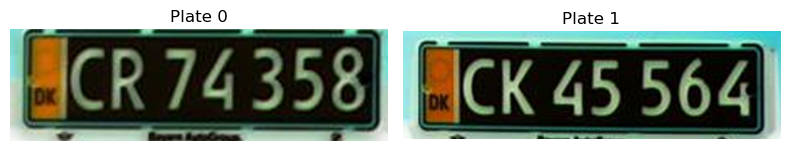

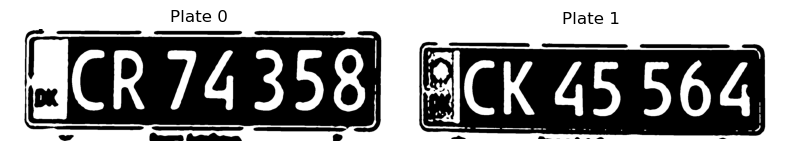

In [ ]:
model = YOLO("my_model.pt")
recognise_license_plates('test2.jpg', model)
# recognise_license_plates('test3.jpg', model)
recognise_license_plates('test4.jpg', model)
recognise_license_plates('test6.jpg', model)